In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Basics

In [5]:
# requires_grad=True
x = torch.tensor(2.0, requires_grad=True, device=device)
x, x.requires_grad

(tensor(2., device='cuda:0', requires_grad=True), True)

In [6]:
# default : requires_grad=False
w = torch.tensor(5.0, device=device)
w, w.requires_grad

(tensor(5., device='cuda:0'), False)

In [7]:
# y : requires_grad=True. 연산에 참여하는 x가 grade 계산을 해야 하기 때문.
y = x * w
y, y.requires_grad

(tensor(10., device='cuda:0', grad_fn=<MulBackward0>), True)

In [8]:
print(f"y.grad_fn: {y.grad_fn}") # Shows the function that created y (e.g., <MulBackward0>)
print(f"x.grad_fn: {x.grad_fn}") # x is a leaf tensor created by user, so grad_fn is None
print(f"w.grad_fn: {w.grad_fn}") # w does not require grad, so grad_fn is None

y.grad_fn: <MulBackward0 object at 0x7c71cca25ab0>
x.grad_fn: None
w.grad_fn: None


In [9]:
z = y**2 + x # z = (2*5)^2 + 2 = 10^2 + 2 = 100 + 2 = 102
z, z.grad_fn

(tensor(102., device='cuda:0', grad_fn=<AddBackward0>),
 <AddBackward0 at 0x7c71cca26530>)

In [10]:
# Compute gradients of z with respect to all tensors with requires_grad=True
# that z depends on (in this case, only x, as w.requires_grad=False)
z.backward() # dz/dx is computed

In [11]:
# dz/dx : x를 아주 조금 늘리면 z가 그의 약 101배 속도로 증가한다는 뜻
x.grad, w.grad

(tensor(101., device='cuda:0'), None)

In [12]:
"""Demonstrates requires_grad, grad_fn, backward(), and .grad attribute."""
print("\nSection 2: PyTorch Autograd: The Basics")
print("-" * 70)

# --- Tensors and `requires_grad` ---
print("\n--- Tensors and `requires_grad` ---")
# Create a tensor that requires gradient tracking
x = torch.tensor(2.0, requires_grad=True, device=device)
print(f"x: {x}, requires_grad: {x.requires_grad}")

# Create a tensor that does not require gradients (default)
w = torch.tensor(5.0, device=device)
print(f"w: {w}, requires_grad: {w.requires_grad}")

# Operations involving a tensor with requires_grad=True will result in a tensor that also requires_grad
y = x * w # y will require gradients because x does
print(f"y = x * w: {y}, requires_grad: {y.requires_grad}")

# --- The `grad_fn` (Gradient Function) ---
print("\n--- The `grad_fn` (Gradient Function) ---")
print(f"y.grad_fn: {y.grad_fn}") # Shows the function that created y (e.g., <MulBackward0>)
print(f"x.grad_fn: {x.grad_fn}") # x is a leaf tensor created by user, so grad_fn is None
print(f"w.grad_fn: {w.grad_fn}") # w does not require grad, so grad_fn is None

# --- Computing Gradients: `backward()` ---
print("\n--- Computing Gradients: `backward()` ---")
# Let's define a scalar output for simplicity
z = y**2 + x # z = (2*5)^2 + 2 = 10^2 + 2 = 100 + 2 = 102
print(f"z = y**2 + x: {z}, grad_fn: {z.grad_fn}")

# Compute gradients of z with respect to all tensors with requires_grad=True
# that z depends on (in this case, only x, as w.requires_grad=False)
z.backward() # dz/dx is computed

# --- Accessing Gradients: `.grad` attribute ---
print("\n--- Accessing Gradients: `.grad` attribute ---")
# dz/dx = d/dx ((x*w)^2 + x) = 2*(x*w)*w + 1 = 2*x*w^2 + 1
# At x=2, w=5: dz/dx = 2*2*5^2 + 1 = 4*25 + 1 = 100 + 1 = 101
print(f"Gradient dz/dx: {x.grad}")
print(f"Gradient dz/dw (w.grad): {w.grad}") # w.grad is None because w.requires_grad was False

# Another example
a = torch.tensor(3.0, requires_grad=True, device=device)
b = a * a # b = 9
out = b.mean() # For a single element tensor, mean is itself. Scalar output.
out.backward()
print(f"a: {a}, Gradient dout/da: {a.grad}") # d(a^2)/da = 2a = 6


Section 2: PyTorch Autograd: The Basics
----------------------------------------------------------------------

--- Tensors and `requires_grad` ---
x: 2.0, requires_grad: True
w: 5.0, requires_grad: False
y = x * w: 10.0, requires_grad: True

--- The `grad_fn` (Gradient Function) ---
y.grad_fn: <MulBackward0 object at 0x7c70c7bcf580>
x.grad_fn: None
w.grad_fn: None

--- Computing Gradients: `backward()` ---
z = y**2 + x: 102.0, grad_fn: <AddBackward0 object at 0x7c7228c1e860>

--- Accessing Gradients: `.grad` attribute ---
Gradient dz/dx: 101.0
Gradient dz/dw (w.grad): None
a: 3.0, Gradient dout/da: 6.0



Section 3: The Computational Graph
----------------------------------------------------------------------
PyTorch uses dynamic computational graphs (define-by-run).
Leaf tensor a: is_leaf=True, requires_grad=True, grad_fn=None
Leaf tensor b: is_leaf=True, requires_grad=True, grad_fn=None
Intermediate tensor c = a + b: is_leaf=False, requires_grad=True, grad_fn=<AddBackward0 object at 0x7c70c7bec4c0>
Intermediate tensor d = c * 3: is_leaf=False, requires_grad=True, grad_fn=<MulBackward0 object at 0x7c70c7bec4c0>
Gradient dd/da: 3.0
Gradient dd/db: 3.0
Gradient dd/dc (c.grad): None


/tmp/ipykernel_344746/1152194936.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f"Gradient dd/dc (c.grad): {c.grad}") # None by default for non-leaf unless retain_grad() is used


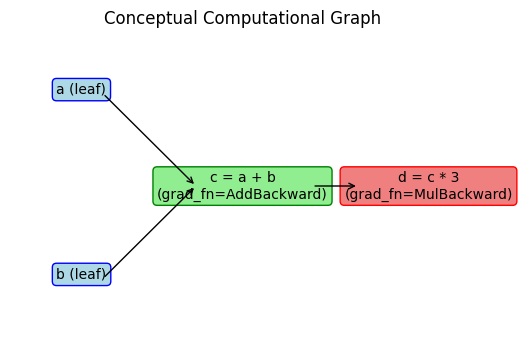

In [13]:
"""Illustrates the concept of the dynamic computational graph."""
print("\nSection 3: The Computational Graph")
print("-" * 70)
print("PyTorch uses dynamic computational graphs (define-by-run).")

a = torch.tensor(2.0, requires_grad=True, device=device)
b = torch.tensor(4.0, requires_grad=True, device=device)
print(f"Leaf tensor a: is_leaf={a.is_leaf}, requires_grad={a.requires_grad}, grad_fn={a.grad_fn}")
print(f"Leaf tensor b: is_leaf={b.is_leaf}, requires_grad={b.requires_grad}, grad_fn={b.grad_fn}")

c = a + b # c is an intermediate tensor (non-leaf)
print(f"Intermediate tensor c = a + b: is_leaf={c.is_leaf}, requires_grad={c.requires_grad}, grad_fn={c.grad_fn}")

d = c * 3 # d is another intermediate tensor
print(f"Intermediate tensor d = c * 3: is_leaf={d.is_leaf}, requires_grad={d.requires_grad}, grad_fn={d.grad_fn}")

# The graph is: a --(+)--> c --(*)--> d
#               b --(+)-->
#               3 --(*)-->

# Perform backward pass
d.backward() # Computes dd/da and dd/db
             # dd/dc = 3
             # dc/da = 1, dc/db = 1
             # dd/da = (dd/dc) * (dc/da) = 3 * 1 = 3
             # dd/db = (dd/dc) * (dc/db) = 3 * 1 = 3

print(f"Gradient dd/da: {a.grad}")
print(f"Gradient dd/db: {b.grad}")
print(f"Gradient dd/dc (c.grad): {c.grad}") # None by default for non-leaf unless retain_grad() is used

# Simple graph visualization concept (manual plotting)
fig, ax = plt.subplots(figsize=(6,4))
ax.text(0.1, 0.8, "a (leaf)", bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', ec='blue', lw=1))
ax.text(0.1, 0.2, "b (leaf)", bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', ec='blue', lw=1))
ax.text(0.5, 0.5, "c = a + b\n(grad_fn=AddBackward)", ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', fc='lightgreen', ec='green', lw=1))
ax.text(0.9, 0.5, "d = c * 3\n(grad_fn=MulBackward)", ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', fc='lightcoral', ec='red', lw=1))
ax.annotate("", xy=(0.4, 0.5), xytext=(0.2, 0.8), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.4, 0.5), xytext=(0.2, 0.2), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.75, 0.5), xytext=(0.65, 0.5), arrowprops=dict(arrowstyle="->"))
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off'); plt.title("Conceptual Computational Graph")
plt.show()
plt.close()